# Playing Card Value - Image Regression
Using Model VGG19

## Install & Setup Library used

In [ ]:
!pip install torch
!pip install torch-summary
!pip install torchvision
!pip install opencv-contrib-python

In [ ]:
import random
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
import os

## Preprocessing

### Setup Engine

In [ ]:
seed_val = 1906350793
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
if torch.cuda.is_available():
  torch.cuda.manual_seed_all(seed_val)

In [ ]:
if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('Tersedia sejumlah %d GPU(s).' % torch.cuda.device_count())
    print('GPU yang akan digunakan:', torch.cuda.get_device_name(0))
else:
    print('Tidak mendukung GPU; hanya CPU')
    device = torch.device("cpu")

Tidak mendukung GPU; hanya CPU


### Setup directory & dataset

#### Directory used 
Images after passed preprocessing using library rembg used for training and testing

In [ ]:
directory_train = 'train'
directory_test = 'test/'
suffix = 'playing-card-value\\'
directory_train_csv = 'train.csv'
list_img = []
batch_size = 16

#### Setup dataframe for dataset

In [ ]:
df = pd.read_csv(os.path.join(os.getcwd(), suffix+ directory_train_csv))
df_filename = df.copy().set_index('Filename')
filenames = df["Filename"]
train_filenames, valid_filenames = filenames.iloc[:3501], filenames.iloc[3501:]

In [ ]:
#######################################################
#      Create dictionary for class indexes
#######################################################

idx_to_class = {i:j for i, j in enumerate(df['Total'].values)}
class_to_idx = {value:key for key,value in idx_to_class.items()}

In [ ]:
new_df = pd.DataFrame(columns=['Filename','Total'])    
dict_res = {'Filename':[], 'Total':[]}

### CardDataset Class
Ref: https://towardsdatascience.com/custom-dataset-in-pytorch-part-1-images-2df3152895

In [ ]:
from torch.utils.data import Dataset
import cv2
from skimage import io, color, filters, util

#######################################################
#               Define Dataset Class
#######################################################

class CardDataset(Dataset):
    def __init__(self, image_paths, label_df, folder_path, transform=False):
        self.image_paths = image_paths
        self.transform = transform
        self.label_df = label_df
        self.folder_path = folder_path
        
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_filepath = self.image_paths.iloc[idx]
        image = cv2.imread(os.path.join(self.folder_path,image_filepath))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        
        #whites
        light = (145, 60, 255)
        dark = (0,10,150)
        mask = cv2.inRange(hsv_image, dark, light)
        #reds
        lower_red = np.array([150,50,50])
        upper_red = np.array([180,255,255])
        mask2 = cv2.inRange(hsv_image, lower_red, upper_red)
        
        mask = mask+mask2
        final = cv2.bitwise_and(image, image, mask=mask)
        
        label = self.label_df.loc[image_filepath, 'Total']
        if self.transform is not None:
            image = self.transform(final)
        
        return image, label, image_filepath
    

In [ ]:
from torchvision.transforms.functional import crop
def crop800(image):
    return crop(image, 300, 0, 350, 850)

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.RandomRotation(degrees=(-20, -10)),
                                transforms.Lambda(crop800),
                                transforms.Pad([0,175,0,325]),
                                transforms.Resize(255)
                               ])

In [ ]:
train_path = os.path.join(os.getcwd(), suffix+directory_train, directory_train)

train_dataset = CardDataset(train_filenames,df_filename,train_path,transform)
valid_dataset = CardDataset(valid_filenames,df_filename,train_path,transform)

In [ ]:
test_path = os.path.join(os.getcwd(), suffix+directory_test, directory_test)
test_dir = {'Filename': [], 'Total': []}
for filename in os.listdir(test_path) :
    test_dir['Filename'].append(filename)
    test_dir['Total'].append(0)

test_df = pd.DataFrame(test_dir)
df_test_filename = test_df.copy().set_index('Filename')
test_filenames= test_df['Filename']

test_dataset = CardDataset(test_filenames,df_test_filename,test_path,transform)

In [ ]:
from torch.utils.data import DataLoader
#######################################################
#                  Define Dataloaders
#######################################################

train_loader = DataLoader(
    train_dataset, batch_size=16, shuffle=True
)

valid_loader = DataLoader(
    valid_dataset, batch_size=16, shuffle=True
)

test_loader = DataLoader(
    test_dataset, batch_size, shuffle=True
)

### Dataset visualization

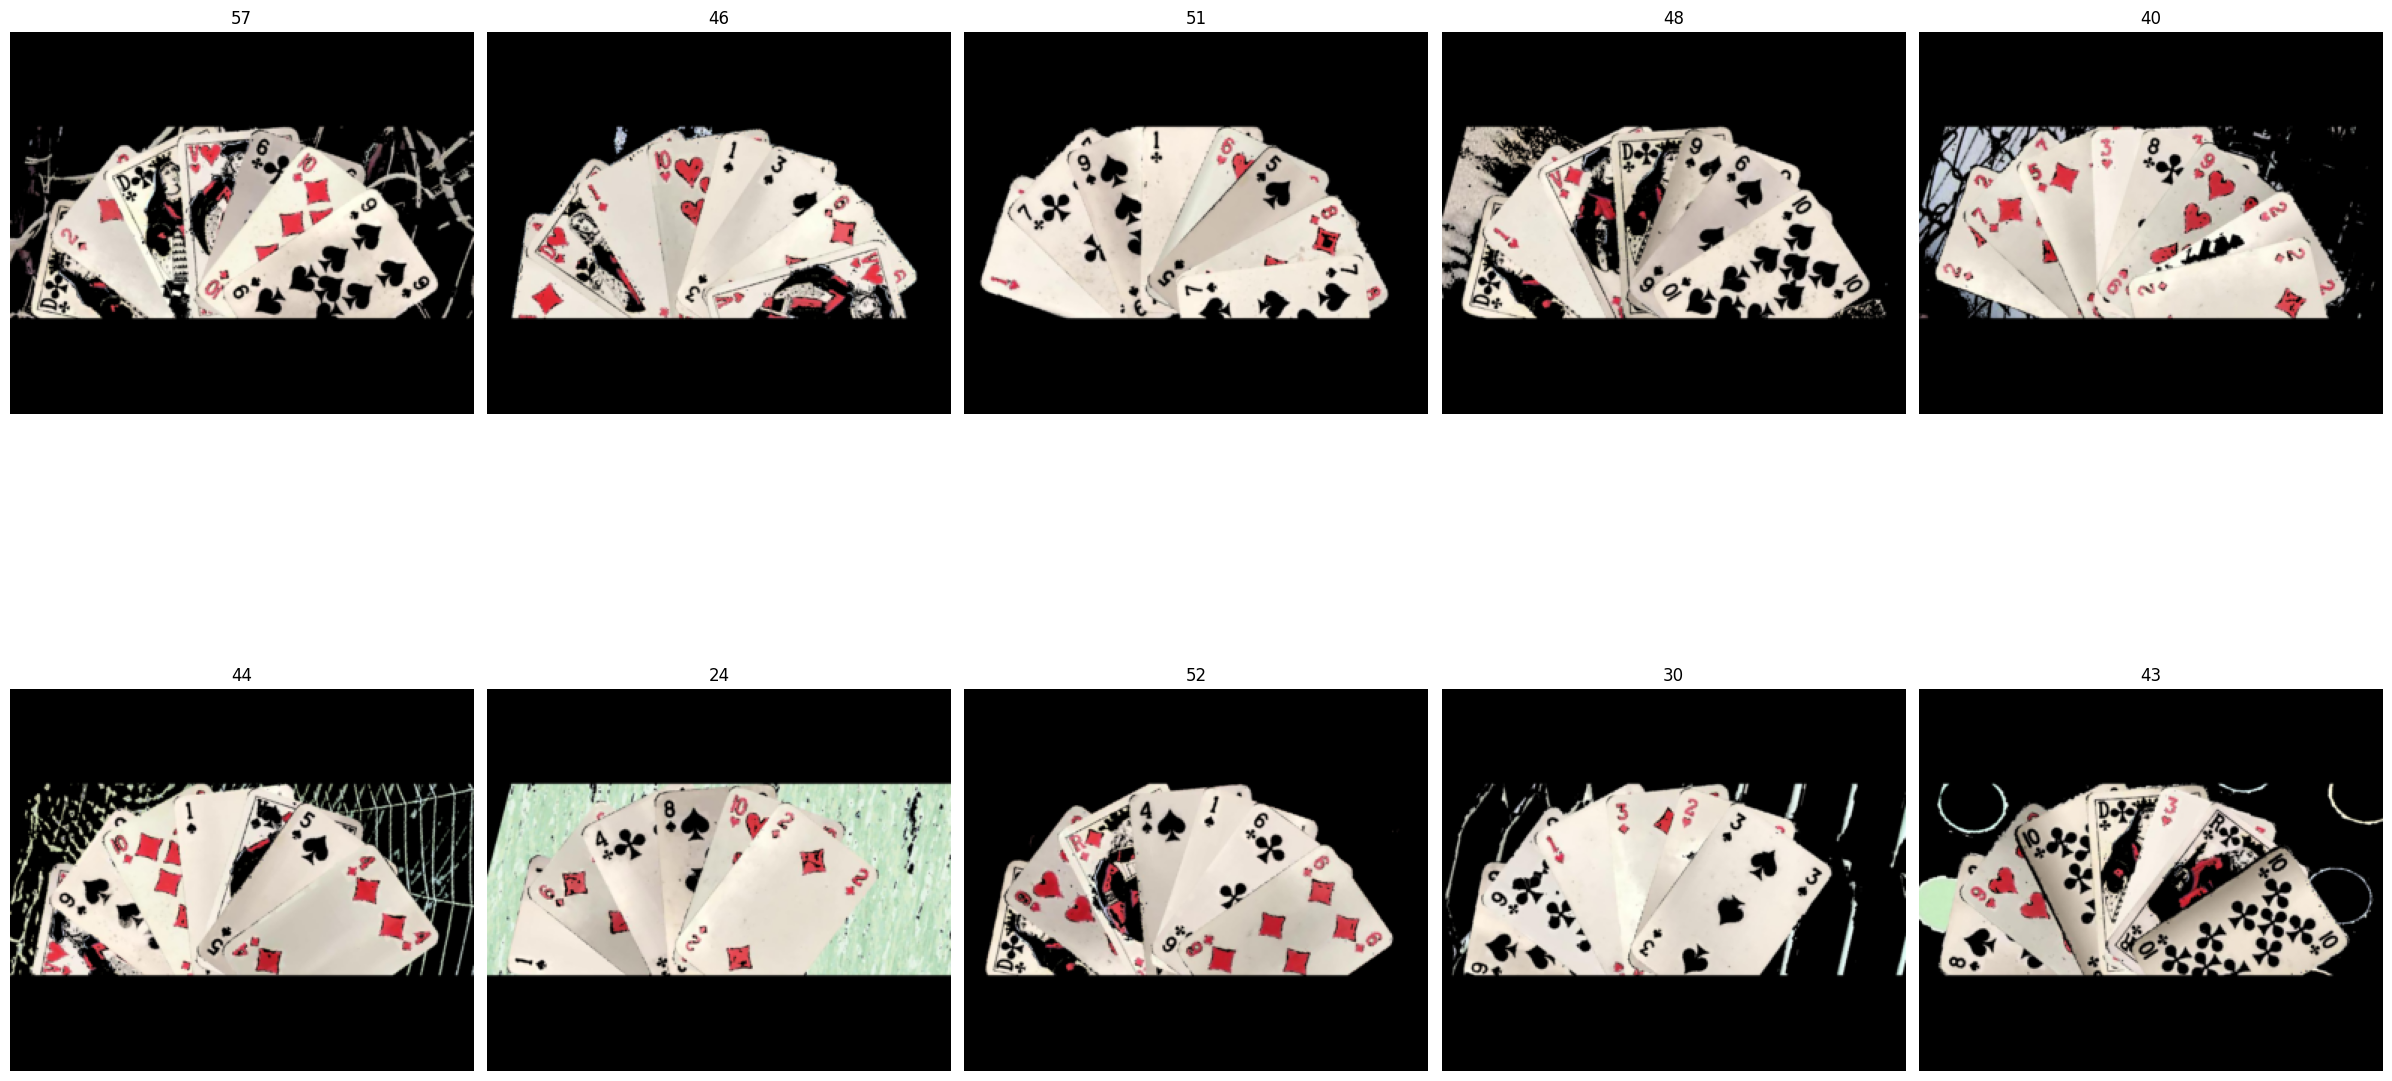

In [ ]:
import matplotlib.pyplot as plt
import copy
%matplotlib inline

#######################################################
           # Visualize Dataset
 #Images are plotted after augmentation
#######################################################

def visualize_augmentations(dataset, idx=0, samples=10, cols=5, random_img = False):
    
    dataset = copy.deepcopy(dataset)
    #we remove the normalize and tensor conversion from our augmentation pipeline
    #print(dataset.transform)
    dataset.transform = transforms.Compose([
                                transforms.ToPILImage(),
                                transforms.RandomRotation(degrees=(-20, -10)),
                                transforms.Lambda(crop800),
                                transforms.Pad([0,175,0,175]),
                                transforms.Resize(255),
                                #transforms.ColorJitter(
                                #    brightness=(1.0,1.2),contrast=(1.0,1.5))
                                ])
    rows = samples // cols
    
        
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(24, 16))
    for i in range(samples):
        if random_img:
            idx = np.random.randint(1,len(train_filenames))
        image, lab, image_filepath = dataset[idx]
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_axis_off()
        ax.ravel()[i].set_title(lab)
    plt.tight_layout(pad=1)
    plt.show()    

visualize_augmentations(train_dataset,np.random.randint(1,len(train_filenames)), random_img = True)

## Model, Training, & Testing

### Model VGG16
Ref: <br>
https://blog.paperspace.com/vgg-from-scratch-pytorch/ <br>
https://jaketae.github.io/study/pytorch-vgg/

In [ ]:
class VGG19(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG19, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer6 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer16 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer7 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer8 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer9 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer14 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer10 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer11 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer12 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer15 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer13 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(7*7*512, 4096),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(4096, num_classes))
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.layer16(out)
        out = self.layer7(out)
        out = self.layer8(out)
        out = self.layer9(out)
        out = self.layer14(out)
        out = self.layer10(out)
        out = self.layer11(out)
        out = self.layer12(out)
        out = self.layer15(out)
        out = self.layer13(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [ ]:
num_classes = 87
num_epochs = 2
learning_rate = 0.005

model = VGG19(num_classes).to(device)
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)  

### Functions to load model

In [ ]:
def load_ckp(checkpoint_fpath, model, optimizer):
    """
    checkpoint_path: path to save checkpoint
    model: model that we want to load checkpoint parameters into       
    optimizer: optimizer we defined in previous training
    """
    # load check point
    checkpoint = torch.load(checkpoint_fpath)
    # initialize state_dict from checkpoint to model
    model.load_state_dict(checkpoint['state_dict'])
    # initialize optimizer from checkpoint to optimizer
    optimizer.load_state_dict(checkpoint['optimizer'])
    # initialize valid_loss_min from checkpoint to valid_loss_min
    valid_loss_min = checkpoint['valid_loss_min']
    # return model, optimizer, epoch value, min validation loss 
    return model, optimizer, checkpoint['epoch'], valid_loss_min.item()

In [ ]:
import shutil, sys   
def save_ckp(state, is_best, checkpoint_path, best_model_path):
    """
    state: checkpoint we want to save
    is_best: is this the best checkpoint; min validation loss
    checkpoint_path: path to save checkpoint
    best_model_path: path to save best model
    """
    f_path = checkpoint_path
    # save checkpoint data to the path given, checkpoint_path
    torch.save(state, f_path)
    # if it is a best model, min validation loss
    if is_best:
        best_fpath = best_model_path
        # copy that checkpoint file to best path given, best_model_path
        shutil.copyfile(f_path, best_fpath)

### Training

In [ ]:
# Train the model
total_step = len(train_loader)

def train(start_epochs,  n_epochs, valid_loss_min_input, 
                training_loader, validation_loader, model, 
                optimizer, checkpoint_path, best_model_path) :
    total_step = len(train_loader)
    
    # initialize tracker for minimum validation loss
    valid_loss_min = valid_loss_min_input 

    print('> start training...')

    for epoch in range(start_epochs, n_epochs+1):
        valid_loss = 0

        print('...epoch : '+ str(epoch) + '...')
        for i, (images, labels, image_filepath) in enumerate(training_loader):  
            #print(images)
            print('...load image '+ str(i) +'...')
            # Move tensors to the configured device
            images = images.to(device)
            labels = labels.to(device)
            #print(labels)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                    .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
                
        # Validation
        with torch.no_grad():
            correct = 0
            total = 0
            for images, labels, image_filepath in validation_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
                valid_loss = criterion(outputs, labels)
                del images, labels, outputs
        
            print('Accuracy of the network on the {} validation images: {} %'.format(5000, 100 * correct / total))
            
            # create checkpoint variable and add important data
            checkpoint = {
                'epoch': epoch + 1,
                'valid_loss_min': valid_loss,
                'state_dict': model.state_dict(),
                'optimizer': optimizer.state_dict()
            }
        
            # save checkpoint
            save_ckp(checkpoint, False, checkpoint_path, best_model_path)
        
            ## TODO: save the model if validation loss has decreased
            if valid_loss <= valid_loss_min:
                print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,valid_loss))
                # save checkpoint as best model
                save_ckp(checkpoint, True, checkpoint_path, best_model_path)
                valid_loss_min = valid_loss
                    
        print('############# Epoch {}  Done   #############\n'.format(epoch))

### Testing

In [ ]:
def test() :
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels, image_filepath in test_loader:
            print(image_filepath)
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            for path in image_filepath:
                dict_res['Filename'].append(path)
            for res in predicted :
                dict_res['Total'].append(int(res))
            
            del images, labels, outputs

    print(dict_res)

    print('Accuracy of the network on the {} test images: {} %'.format(1000, 100 * correct / total))   

## Main

In [ ]:
if __name__ == "__main__":
    
    # Let's build our model
    checkpoint_path = 'current_checkpoint.pt'
    best_model = 'best_model.pt'
    model, optimizer, start_epoch, valid_loss_min = load_ckp(checkpoint_path, model, optimizer)
    train(start_epoch, 9, valid_loss_min, train_loader, valid_loader, model, optimizer,checkpoint_path,best_model)
    print('...Finished Training')

    dict_res = {'Filename':[], 'Total':[]}
    test()

    temp = pd.DataFrame(dict_res)
    temp.to_csv('playing-card-value/test.csv',index=False)

> start training...
...epoch : 7...
...load image 0...
...load image 1...
...load image 2...
...load image 3...
...load image 4...
...load image 5...
...load image 6...
...load image 7...
...load image 8...
...load image 9...
...load image 10...
...load image 11...
...load image 12...
...load image 13...
...load image 14...
...load image 15...
...load image 16...
...load image 17...
...load image 18...
...load image 19...
...load image 20...
...load image 21...
...load image 22...
...load image 23...
...load image 24...
...load image 25...
...load image 26...
...load image 27...
...load image 28...
...load image 29...
...load image 30...
...load image 31...
...load image 32...
...load image 33...
...load image 34...
...load image 35...
...load image 36...
...load image 37...
...load image 38...
...load image 39...
...load image 40...
...load image 41...
...load image 42...
...load image 43...
...load image 44...
...load image 45...
...load image 46...
...load image 47...
...load image 